In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

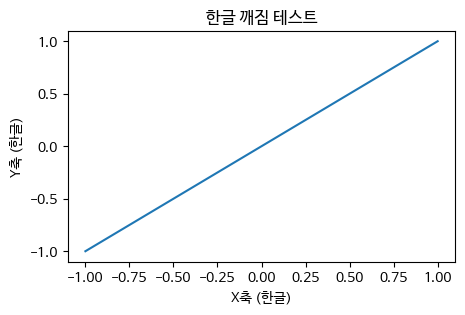

In [ ]:
# 1. 폰트 설치 및 캐시 업데이트 (실행 후 '런타임 재시작' 필요)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 2. 폰트 설정 및 라이브러리 임포트
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# 한글 폰트 경로 설정 (나눔바른고딕)
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

print("설치가 완료되었습니다. [런타임] -> [세션 다시 시작] 을 클릭한 뒤, 이 셀을 한 번 더 실행해주세요!")

# --- 확인용 테스트 그래프 ---
plt.figure(figsize=(5,3))
plt.title("한글 깨짐 테스트")
plt.plot([-1, 0, 1], [-1, 0, 1])
plt.xlabel("X축 (한글)")
plt.ylabel("Y축 (한글)")
plt.show()

In [ ]:
import pandas as pd
import numpy as np

file_path = '/content/drive/MyDrive/CV/processed_HN07~24.csv'
new_df = pd.read_csv(file_path, low_memory=False)

In [ ]:
# 1. 제거 전 행 개수 저장
before_count = len(new_df)

# 2. HE_HbA1c 또는 wt_tot 컬럼에 결측치가 있는 행 제거
new_df = new_df.dropna(subset=['HE_HbA1c', 'wt_tot'])

# 3. 제거 후 행 개수 저장
after_count = len(new_df)
deleted_count = before_count - after_count

# 4. 삭제 비율 계산
# 0으로 나누는 에러를 방지하기 위해 조건문을 넣거나 간단히 계산합니다.
deleted_percent = (deleted_count / before_count) * 100

# 5. 결과 출력
print(f"제거 전 데이터 개수: {before_count:,}개")
print(f"제거 후 데이터 개수: {after_count:,}개")
print("-" * 30)
print(f"삭제된 결측치 개수: {deleted_count:,}개")
print(f"삭제된 비율: {deleted_percent:.2f}%")

제거 전 데이터 개수: 111,368개
제거 후 데이터 개수: 71,871개
------------------------------
삭제된 결측치 개수: 39,497개
삭제된 비율: 35.47%


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 9.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
new_df = new_df[(new_df['HE_HbA1c'] >= 4.7) & (new_df['HE_HbA1c'] < 8.0)].copy()

In [ ]:
# 0. 타겟 및 제외 컬럼 정의
# ============================================================
target_col = 'HE_HbA1c'

exclude_cols = [
    target_col,
    'year', 'HE_chol', 'DE1_dg',  # 연도 분리용
    'wt_tot', 'HE_glu', 'D_2_1', 'DJ2_dg', 'DI3_dg', 'DI4_dg', ' DI5_dg', 'DI6_dg'
  # 국민건강영양조사 가중치
    # 필요 시 제외할 컬럼 여기에 추가
]

# ============================================================
# 1. 독립변수 정의 (제외 리스트 기반 자동 생성)
# ============================================================
feature_cols = [col for col in new_df.columns if col not in exclude_cols]


# ============================================================
# 5. 데이터 준비
# ============================================================

# 데이터 복사
df_clean = new_df[feature_cols + [target_col, 'year', 'wt_tot']].copy()

# Train/Val/ test 분리
train_val_data = df_clean[df_clean['year'].between(2007, 2022)].copy()
test_data = df_clean[df_clean['year'].isin([2023, 2024])].copy()

# ============================================================
# 6. Train/Validation 분리 (80% / 20%)
# ============================================================
print("\nTrain/Validation 데이터 분리 중...")

train_data, val_data = train_test_split(
    train_val_data,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# X, y, wt_tot 분리
X_train = train_data[feature_cols]
y_train = train_data[target_col]
wt_train = train_data['wt_tot']

X_val = val_data[feature_cols]
y_val = val_data[target_col]
wt_val = val_data['wt_tot']  # 추가

X_test = test_data[feature_cols]
y_test = test_data[target_col]


# ============================================================
# 8. 샘플 가중치 계산
# ============================================================
print("\n샘플 가중치 계산 중...")
sample_weights = wt_train  # wt_tot만 사용

print(f"\n[가중치 통계]")
print(f"  최소값: {sample_weights.min():.4f}")
print(f"  최대값: {sample_weights.max():.4f}")
print(f"  평균값: {sample_weights.mean():.4f}")


# ============================================================
# ============================================================
# 9. 범주형 변수 처리 및 자동 인식 (자동화 버전)
# ============================================================

# 1. 명시적 수치형 변수 목록 정의
numeric_etc_cols = [
    # 수치형
    'age', 'year'
    "HE_BMI", "HE_wc", "N_WAT_C", "NF_WATER",
    "N_FAT", "N_CHOL", "N_CHO", "N_TDF",
    "N_SUGAR", "N_NA",
    "HE_HbA1c", "HE_TG", "HE_HDL_st2",
    "HE_glu", "HE_LDL_drct", "HE_chol", 'N_EN'

    # 수면
    "BP16_1", "BP16_11", "BP16_12", "BP16_13", "BP16_14", "BP16_2", "BP16_21", "BP16_22", "BP16_23", "BP16_24", "BP8", "sleep_gap"
    #가족력
    '고혈압가족력점수', '고지혈증가족력점수', '허혈성심장질환가족력점수',
    '뇌졸중가족력점수', '당뇨병가족력점수', '암가족력점수',
    #신체활동
    'MET_work', 'MET_trans', 'MET_leisure', 'MET_total', 'sitting_time', 'BMR', 'TDEE', 'energy_balance_ratio',
#영양섭취
    'carb_ratio', 'fat_ratio', 'prot_ratio', 'nutrient_imbalance' 'carb_fat_balance',
    'N_SFA', 'sfa_adequacy_ratio', 'sfa_over_intake', 'N_TDF', 'N_EN', 'fiber_adequacy_ratio', 'wt_tot'

    #추가 제외 변수
]

# 실제 feature_cols에 존재하는 수치형 변수만 사용
numeric_etc_cols = [col for col in numeric_etc_cols if col in feature_cols]

# 2. 범주형 변수 = feature_cols - numeric_etc_cols
cat_features = [col for col in feature_cols if col not in numeric_etc_cols]

# 3. 범주형 변수 전처리 (CatBoost 요구사항)
for col in cat_features:
    if col in X_train.columns:
        # NaN → 'missing'
        X_train[col] = X_train[col].fillna('missing')
        X_val[col]   = X_val[col].fillna('missing')
        X_test[col]  = X_test[col].fillna('missing')

        # 문자열 변환
        X_train[col] = X_train[col].astype(str)
        X_val[col]   = X_val[col].astype(str)
        X_test[col]  = X_test[col].astype(str)

print("범주형 변수 변환 완료!")



# ============================================================
# 10. CatBoost 모델 학습
# ============================================================
print("\n" + "="*60)
print("CatBoost 모델 학습 시작")
print("="*60)

model = CatBoostRegressor(
    iterations=2000,              # 5000 → 2000 (줄임)
    learning_rate=0.1,            # 0.05 → 0.1 (높임)
    depth=4,                      # 6 → 4 (줄임)
    l2_leaf_reg=10,               # ⭐ L2 정규화 추가
    loss_function='RMSE',
    eval_metric='MAE',
    cat_features=cat_features,
    random_seed=42,
    early_stopping_rounds=50,     # 100 → 50 (더 빨리 멈춤)
    verbose=100,
    task_type='CPU',
    use_best_model=True,
    bootstrap_type='Bernoulli',   # ⭐ 부트스트랩 추가
    subsample=0.8                 # ⭐ 샘플링 비율 80%
)


# 학습 (가중치 적용, Validation set으로 평가)
model.fit(
    X_train,
    y_train,
    sample_weight=sample_weights,
    eval_set=(X_val, y_val),
    plot=False
)


print("\n학습 완료!")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1️⃣ 예측
y_test_pred = model.predict(X_test)

# 2️⃣ 지표 계산
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2 = r2_score(y_test, y_test_pred)

# 3️⃣ 결과 출력
print("\n" + "="*60)
print("Test Set 성능 평가")
print("="*60)

print(f"Test MAE      : {mae:.4f}")
print(f"Test RMSE     : {rmse:.4f}")
print(f"Test R² Score : {r2:.4f}")
print(f"예측 최소값     : {y_test_pred.min():.4f}")
print(f"예측 최대값     : {y_test_pred.max():.4f}")


Train/Validation 데이터 분리 중...

샘플 가중치 계산 중...

[가중치 통계]
  최소값: 84.3383
  최대값: 38444.5608
  평균값: 8155.6000


/tmp/ipython-input-620123917.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].fillna('missing')
/tmp/ipython-input-620123917.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col]   = X_val[col].fillna('missing')
/tmp/ipython-input-620123917.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

범주형 변수 변환 완료!

CatBoost 모델 학습 시작
0:	learn: 0.3826746	test: 0.3946728	best: 0.3946728 (0)	total: 118ms	remaining: 3m 55s
100:	learn: 0.3274589	test: 0.3425743	best: 0.3425743 (100)	total: 26.5s	remaining: 8m 18s
200:	learn: 0.3018508	test: 0.3220741	best: 0.3220741 (200)	total: 1m 5s	remaining: 9m 49s
300:	learn: 0.2970316	test: 0.3191872	best: 0.3191843 (299)	total: 1m 41s	remaining: 9m 32s
400:	learn: 0.2946721	test: 0.3183467	best: 0.3183304 (390)	total: 2m 17s	remaining: 9m 8s
500:	learn: 0.2931178	test: 0.3181514	best: 0.3181180 (491)	total: 2m 53s	remaining: 8m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3179617855
bestIteration = 544

Shrink model to first 545 iterations.

학습 완료!

Test Set 성능 평가
Test MAE      : 0.3323
Test RMSE     : 0.4464
Test R² Score : 0.3335
예측 최소값     : 5.0033
예측 최대값     : 7.1132



SHAP 값 계산 및 시각화

SHAP 값 계산 중... (시간이 걸릴 수 있습니다)
SHAP 값 계산 완료!

Feature Importance (CatBoost)
             feature  importance
               HE_wc   12.233272
              DI2_dg    8.628066
          N_DIET_WHY    7.957929
              DI1_dg    6.500125
                 age    5.690714
             marri_1    3.957570
            당뇨병가족력점수    3.761415
                 edu    2.460479
            EC_wht_5    2.453760
               LW_mt    2.419509
            당뇨병가족력유무    2.260406
               BS3_1    2.127896
                occp    1.999379
            고혈압가족력점수    1.800769
              DJ8_dg    1.688498
               HE_fh    1.667480
              DM4_dg    1.451461
            LK_LB_US    1.323872
             LQ_1EQL    1.304030
           sleep_gap    1.170862
                cfam    1.125086
          pa_aerobic    1.111442
              BD1_11    1.083076
             LS_VEG2    1.078621
             BS6_2_1    1.076868
               N_SFA    1.069779
               

/usr/local/lib/python3.12/dist-packages/shap/plots/_waterfall.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


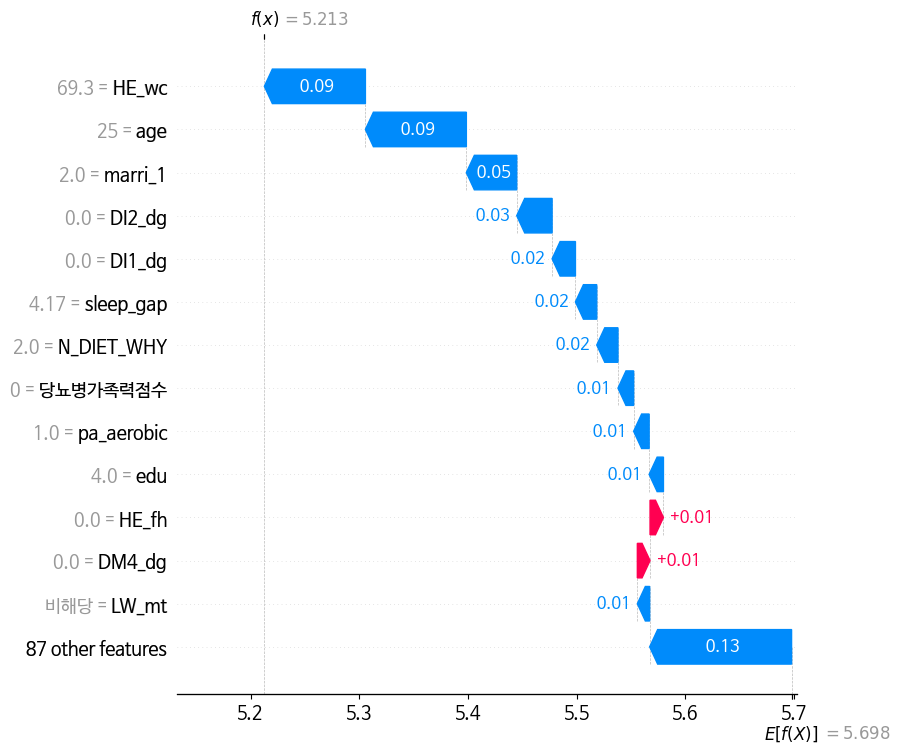


[샘플 1] 예측 해석:
예측값: 5.73
실제값: 5.20
오차: 0.53


/usr/local/lib/python3.12/dist-packages/shap/plots/_waterfall.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


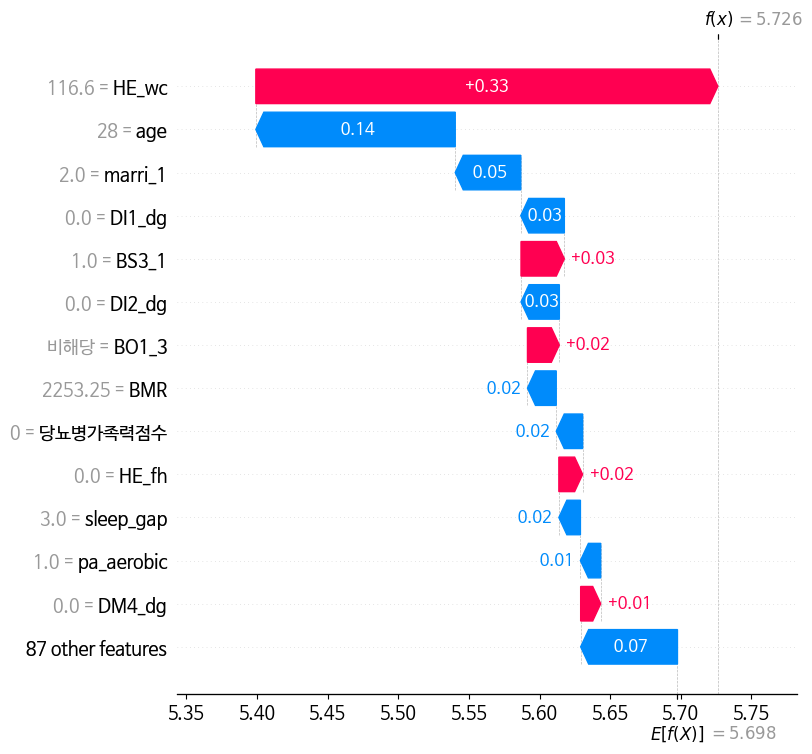


전체 특성 기여도 분석 (Beeswarm Plot)


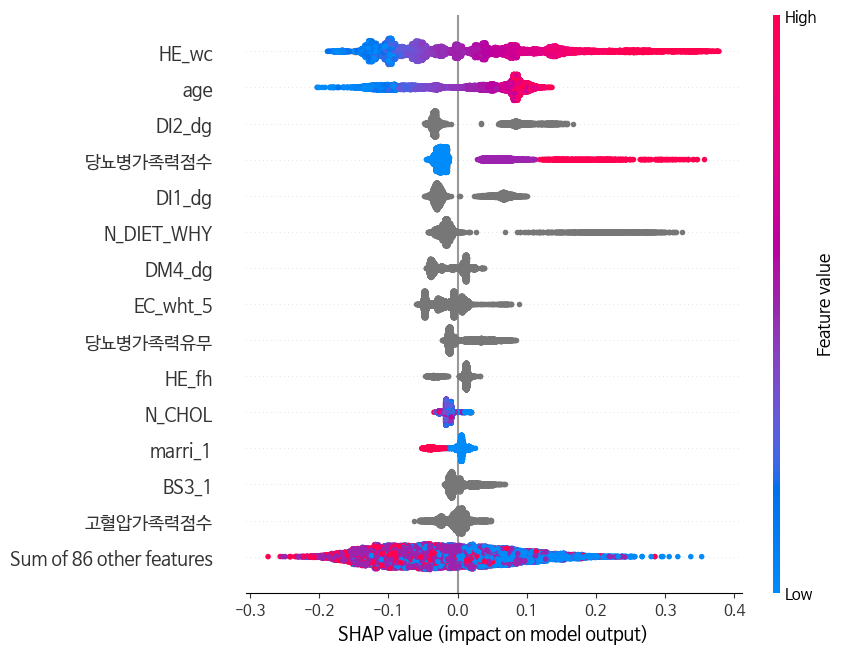


SHAP 기반 Feature Importance (Bar Plot)


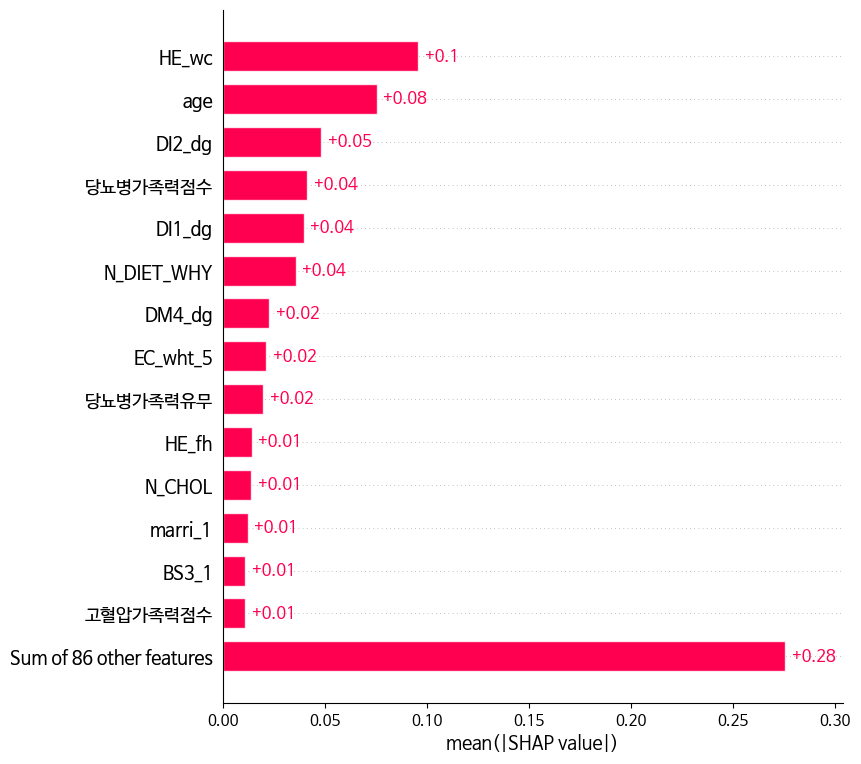


Summary Plot (분포 포함)


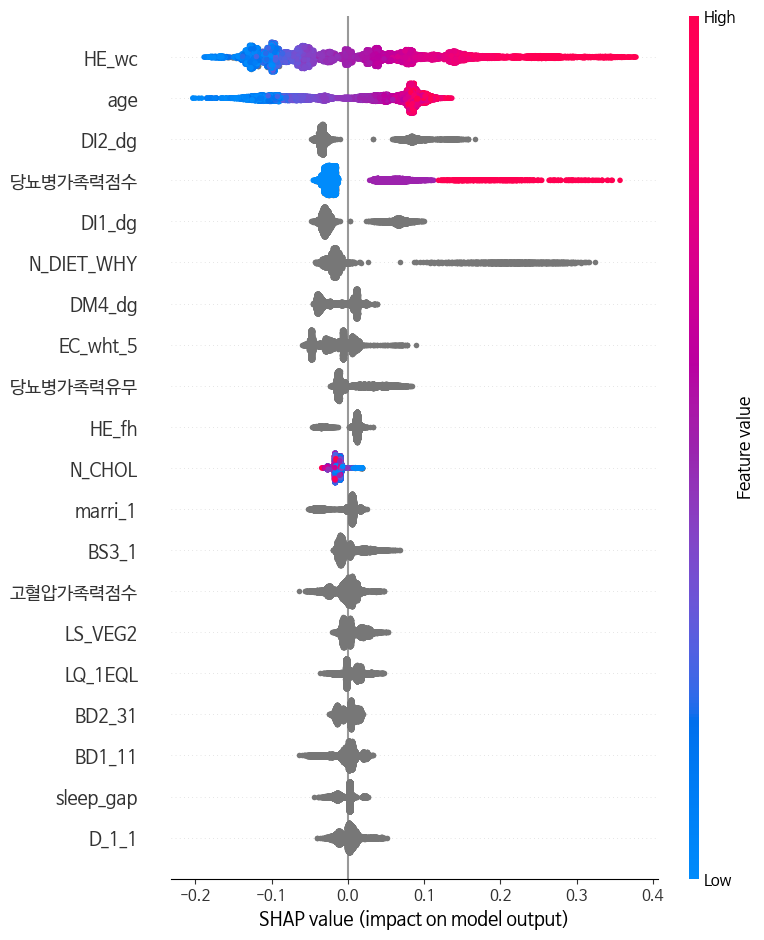


SHAP 값 통계 요약

평균 절대 SHAP 값 (상위 10개):
HE_wc         0.095741
age           0.075481
DI2_dg        0.048409
당뇨병가족력점수      0.041293
DI1_dg        0.039682
N_DIET_WHY    0.035856
DM4_dg        0.022946
EC_wht_5      0.021369
당뇨병가족력유무      0.019855
HE_fh         0.014197
dtype: float64


In [ ]:
# ============================================================
# SHAP 분석 시작
# ============================================================
print("\n" + "="*60)
print("SHAP 값 계산 및 시각화")
print("="*60)

# SHAP 라이브러리 설치 (필요시)
try:
    import shap
except ImportError:
    !pip install shap
    import shap

# ============================================================
# 1. SHAP Explainer 생성 (범주형 변수 처리)
# ============================================================
print("\nSHAP 값 계산 중... (시간이 걸릴 수 있습니다)")

# 방법 1: feature_perturbation="tree_path_dependent" 사용 (배경 데이터 없이)
explainer = shap.TreeExplainer(
    model,
    feature_perturbation="tree_path_dependent"
)

# 테스트 데이터에 대한 SHAP 값 계산
shap_values = explainer(X_test)

print("SHAP 값 계산 완료!")

# ============================================================
# 2. 모델 계수 출력 (Feature Importance)
# ============================================================
print("\n" + "="*60)
print("Feature Importance (CatBoost)")
print("="*60)

feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Feature Importance를 데이터프레임으로 정리
import pandas as pd
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(fi_df.to_string(index=False))

# ============================================================
# 3. 개별 예측 해석 - Waterfall Plot
# ============================================================
print("\n" + "="*60)
print("개별 샘플 분석 (Waterfall Plot)")
print("="*60)

print("\n[샘플 0] 예측 해석:")
print(f"예측값: {y_test_pred[0]:.2f}")
print(f"실제값: {y_test.iloc[0]:.2f}")
print(f"오차: {abs(y_test_pred[0] - y_test.iloc[0]):.2f}")

shap.plots.waterfall(shap_values[0], max_display=14)

print("\n[샘플 1] 예측 해석:")
print(f"예측값: {y_test_pred[1]:.2f}")
print(f"실제값: {y_test.iloc[1]:.2f}")
print(f"오차: {abs(y_test_pred[1] - y_test.iloc[1]):.2f}")

shap.plots.waterfall(shap_values[1], max_display=14)

# ============================================================
# 4. 전체 데이터 해석 - Beeswarm Plot
# ============================================================
print("\n" + "="*60)
print("전체 특성 기여도 분석 (Beeswarm Plot)")
print("="*60)

shap.plots.beeswarm(shap_values, max_display=15)

# ============================================================
# 5. Feature Importance - Bar Plot (SHAP 기반)
# ============================================================
print("\n" + "="*60)
print("SHAP 기반 Feature Importance (Bar Plot)")
print("="*60)

shap.plots.bar(shap_values, max_display=15)

# ============================================================
# 6. Summary Plot (Violin 스타일)
# ============================================================
print("\n" + "="*60)
print("Summary Plot (분포 포함)")
print("="*60)

shap.summary_plot(shap_values.values, X_test, max_display=20)



# ============================================================
# 8. SHAP 값 통계 요약
# ============================================================
print("\n" + "="*60)
print("SHAP 값 통계 요약")
print("="*60)

shap_df = pd.DataFrame(
    shap_values.values,
    columns=X_test.columns
)

# 각 특성의 평균 절대 SHAP 값 계산
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)

print("\n평균 절대 SHAP 값 (상위 10개):")
print(mean_abs_shap.head(10))

In [ ]:
# ============================================================
# 14. 모델 저장
# ============================================================
model.save_model('glucose_catboost_model.cbm')
print("\n모델 저장 완료: glucose_catboost_model.cbm")

print("\n" + "="*60)
print("모든 작업 완료!")
print("="*60)


모델 저장 완료: glucose_catboost_model.cbm

모든 작업 완료!


In [ ]:
# ============================================================
# 15. 저장된 모델 불러오기 및 DE1_dg 기반 2차 보정 모델
# ============================================================

from catboost import CatBoostRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

print("\n" + "="*60)
print("저장된 1차 모델 불러오기")
print("="*60)

# 1차 모델 로드
model_path = '/content/glucose_catboost_model.cbm'
base_model = CatBoostRegressor()
base_model.load_model(model_path)
print("✅ 1차 모델 로드 완료")


# ============================================================
# 16. 1차 모델 예측값 생성
# ============================================================
print("\n" + "="*60)
print("1차 모델 예측값 생성")
print("="*60)

train_base_pred = base_model.predict(X_train)
val_base_pred = base_model.predict(X_val)
test_base_pred = base_model.predict(X_test)

print("✅ 1차 예측 완료")


# ============================================================
# 17. DE1_dg 추출 및 전처리
# ============================================================
print("\n" + "="*60)
print("DE1_dg 데이터 준비")
print("="*60)

# 원본 데이터에서 DE1_dg 추출
train_de1_dg_raw = new_df.loc[train_data.index, 'DE1_dg'].values
val_de1_dg_raw = new_df.loc[val_data.index, 'DE1_dg'].values
test_de1_dg_raw = new_df.loc[test_data.index, 'DE1_dg'].values

# 문자열을 숫자로 변환
def convert_de1_dg(de1_dg_array):
    """DE1_dg를 숫자로 변환: '1.0' → 1, 그 외 → 0"""
    converted = []
    for val in de1_dg_array:
        if val == '1.0' or val == 1.0 or val == 1:
            converted.append(1)
        else:
            converted.append(0)
    return np.array(converted)

train_de1_dg = convert_de1_dg(train_de1_dg_raw)
val_de1_dg = convert_de1_dg(val_de1_dg_raw)
test_de1_dg = convert_de1_dg(test_de1_dg_raw)

print(f"✅ DE1_dg 변환 완료")
print(f"  Train 당뇨 환자 비율: {(train_de1_dg == 1).sum() / len(train_de1_dg) * 100:.1f}%")
print(f"  Val 당뇨 환자 비율: {(val_de1_dg == 1).sum() / len(val_de1_dg) * 100:.1f}%")
print(f"  Test 당뇨 환자 비율: {(test_de1_dg == 1).sum() / len(test_de1_dg) * 100:.1f}%")


# ============================================================
# 18. 2차 보정 모델용 피처 생성
# ============================================================
print("\n" + "="*60)
print("2차 보정 모델용 데이터 생성")
print("="*60)

# 2차 모델 입력: [1차 예측값, DE1_dg]
X_train_meta = pd.DataFrame({
    'base_prediction': train_base_pred,
    'DE1_dg': train_de1_dg
})

X_val_meta = pd.DataFrame({
    'base_prediction': val_base_pred,
    'DE1_dg': val_de1_dg
})

X_test_meta = pd.DataFrame({
    'base_prediction': test_base_pred,
    'DE1_dg': test_de1_dg
})

# 목표값은 실제값과 1차 예측값의 차이 (잔차)
y_train_residual = y_train.values - train_base_pred
y_val_residual = y_val.values - val_base_pred

print("✅ 메타 피처 생성 완료")
print(f"  Train shape: {X_train_meta.shape}")
print(f"  Val shape: {X_val_meta.shape}")
print(f"  Test shape: {X_test_meta.shape}")


# ============================================================
# 19. 2차 보정 모델 학습 (잔차 예측)
# ============================================================
print("\n" + "="*60)
print("2차 보정 모델 학습 시작")
print("="*60)

# 2차 모델: 잔차를 예측하여 1차 예측값 보정
meta_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=3,
    loss_function='RMSE',
    cat_features=['DE1_dg'],  # DE1_dg를 범주형으로 처리
    random_seed=42,
    verbose=100,
    task_type='CPU',
    use_best_model=True
)

meta_model.fit(
    X_train_meta,
    y_train_residual,
    eval_set=(X_val_meta, y_val_residual),
    plot=False
)

print("\n✅ 2차 보정 모델 학습 완료!")


# ============================================================
# 20. 최종 예측 (1차 예측 + 2차 보정)
# ============================================================
print("\n" + "="*60)
print("최종 예측값 생성")
print("="*60)

# 2차 모델로 잔차 예측
train_residual_pred = meta_model.predict(X_train_meta)
val_residual_pred = meta_model.predict(X_val_meta)
test_residual_pred = meta_model.predict(X_test_meta)

# 최종 예측 = 1차 예측 + 보정값
train_final_pred = train_base_pred + train_residual_pred
val_final_pred = val_base_pred + val_residual_pred
test_final_pred = test_base_pred + test_residual_pred

print("✅ 최종 예측 완료")


# ============================================================
# 21. 성능 비교
# ============================================================
print("\n" + "="*60)
print("📊 Test Set 성능 비교")
print("="*60)

# 1차 모델 성능
mae_before = mean_absolute_error(y_test, test_base_pred)
rmse_before = np.sqrt(mean_squared_error(y_test, test_base_pred))
r2_before = r2_score(y_test, test_base_pred)

print("\n[1차 모델 (기본)]")
print(f"  MAE:  {mae_before:.2f} mg/dL")
print(f"  RMSE: {rmse_before:.2f} mg/dL")
print(f"  R²:   {r2_before:.4f}")

# 2차 보정 후 성능
mae_after = mean_absolute_error(y_test, test_final_pred)
rmse_after = np.sqrt(mean_squared_error(y_test, test_final_pred))
r2_after = r2_score(y_test, test_final_pred)

print("\n[2차 보정 모델 (DE1_dg 활용)]")
print(f"  MAE:  {mae_after:.2f} mg/dL")
print(f"  RMSE: {rmse_after:.2f} mg/dL")
print(f"  R²:   {r2_after:.4f}")

print("\n[성능 변화]")
print(f"  MAE 변화:  {mae_after - mae_before:+.2f} mg/dL")
print(f"  RMSE 변화: {rmse_after - rmse_before:+.2f} mg/dL")
print(f"  R² 변화:   {r2_after - r2_before:+.4f}")


# ============================================================
# 22. DE1_dg 그룹별 성능 분석
# ============================================================
print("\n" + "="*60)
print("📊 DE1_dg 그룹별 성능 분석")
print("="*60)

# 당뇨병 환자 (DE1_dg=1)
diabetes_mask = test_de1_dg == 1
if diabetes_mask.sum() > 0:
    print("\n[당뇨병 환자 그룹 (DE1_dg=1)]")
    print(f"  샘플 수: {diabetes_mask.sum()}개")

    mae_diabetes_before = mean_absolute_error(y_test[diabetes_mask], test_base_pred[diabetes_mask])
    mae_diabetes_after = mean_absolute_error(y_test[diabetes_mask], test_final_pred[diabetes_mask])

    print(f"  1차 모델 MAE: {mae_diabetes_before:.2f} mg/dL")
    print(f"  2차 보정 MAE: {mae_diabetes_after:.2f} mg/dL")
    print(f"  개선: {mae_diabetes_after - mae_diabetes_before:+.2f} mg/dL")

    # 평균 보정량
    avg_correction = (test_final_pred[diabetes_mask] - test_base_pred[diabetes_mask]).mean()
    print(f"  평균 보정량: {avg_correction:+.2f} mg/dL")
else:
    print("\n[당뇨병 환자 그룹 (DE1_dg=1)]")
    print("  ⚠️ 테스트 셋에 당뇨병 환자 없음")

# 정상인 (DE1_dg=0)
normal_mask = test_de1_dg == 0
if normal_mask.sum() > 0:
    print("\n[정상인 그룹 (DE1_dg=0)]")
    print(f"  샘플 수: {normal_mask.sum()}개")

    mae_normal_before = mean_absolute_error(y_test[normal_mask], test_base_pred[normal_mask])
    mae_normal_after = mean_absolute_error(y_test[normal_mask], test_final_pred[normal_mask])

    print(f"  1차 모델 MAE: {mae_normal_before:.2f} mg/dL")
    print(f"  2차 보정 MAE: {mae_normal_after:.2f} mg/dL")
    print(f"  개선: {mae_normal_after - mae_normal_before:+.2f} mg/dL")

    # 평균 보정량
    avg_correction = (test_final_pred[normal_mask] - test_base_pred[normal_mask]).mean()
    print(f"  평균 보정량: {avg_correction:+.2f} mg/dL")


# ============================================================
# 23. 예측값 샘플 비교
# ============================================================
print("\n" + "="*60)
print("📋 예측값 샘플 비교 (Test Set)")
print("="*60)

comparison_df = pd.DataFrame({
    'DE1_dg': test_de1_dg[:15],
    'Actual': y_test.values[:15],
    'Pred_1st': test_base_pred[:15],
    'Pred_2nd': test_final_pred[:15],
    'Correction': test_final_pred[:15] - test_base_pred[:15],
    'Error_1st': np.abs(y_test.values[:15] - test_base_pred[:15]),
    'Error_2nd': np.abs(y_test.values[:15] - test_final_pred[:15])
})

print(comparison_df.round(2))


# ============================================================
# 24. 2차 보정 모델 저장
# ============================================================
meta_model.save_model('/content/glucose_meta_model0.cbm')
print("\n✅ 2차 보정 모델 저장 완료: glucose_meta_model.cbm")

print("\n" + "="*60)
print("모든 작업 완료!")
print("="*60)


저장된 1차 모델 불러오기
✅ 1차 모델 로드 완료

1차 모델 예측값 생성
✅ 1차 예측 완료

DE1_dg 데이터 준비
✅ DE1_dg 변환 완료
  Train 당뇨 환자 비율: 9.5%
  Val 당뇨 환자 비율: 9.6%
  Test 당뇨 환자 비율: 11.5%

2차 보정 모델용 데이터 생성
✅ 메타 피처 생성 완료
  Train shape: (46609, 2)
  Val shape: (11653, 2)
  Test shape: (10989, 2)

2차 보정 모델 학습 시작
0:	learn: 0.4306366	test: 0.4348951	best: 0.4348951 (0)	total: 8.52ms	remaining: 4.25s
100:	learn: 0.3953886	test: 0.3995816	best: 0.3995816 (100)	total: 797ms	remaining: 3.15s
200:	learn: 0.3952249	test: 0.3994615	best: 0.3994546 (186)	total: 1.14s	remaining: 1.69s
300:	learn: 0.3950015	test: 0.3995320	best: 0.3994546 (186)	total: 1.49s	remaining: 984ms
400:	learn: 0.3948550	test: 0.3996223	best: 0.3994546 (186)	total: 1.83s	remaining: 451ms
499:	learn: 0.3947465	test: 0.3996998	best: 0.3994546 (186)	total: 2.17s	remaining: 0us

bestTest = 0.3994545884
bestIteration = 186

Shrink model to first 187 iterations.

✅ 2차 보정 모델 학습 완료!

최종 예측값 생성
✅ 최종 예측 완료

📊 Test Set 성능 비교

[1차 모델 (기본)]
  MAE:  0.33 mg/dL
  RMSE: 0.45 m

In [ ]:
# ============================================================
# 부트스트랩 교차검증 (2차 보정 모델)
# ============================================================
from sklearn.utils import resample
import numpy as np

n_bootstrap = 50  # 반복 횟수
bootstrap_results = []

print("부트스트랩 교차검증 시작...")
print("="*60)

for i in range(n_bootstrap):
    # 1. 부트스트랩 샘플링 (복원추출)
    X_boot, y_boot = resample(
        X_train_meta, y_train_residual,
        random_state=i
    )

    # OOB (Out-of-Bag) 샘플 추출
    oob_mask = ~X_train_meta.index.isin(X_boot.index)
    X_oob = X_train_meta[oob_mask]
    y_oob = y_train_residual[oob_mask]

    if len(X_oob) == 0:
        continue

    # 2. 2차 보정 모델 학습
    boot_model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=3,
        loss_function='RMSE',
        cat_features=['DE1_dg'],
        random_seed=i,
        verbose=0,
        task_type='CPU'
    )

    boot_model.fit(X_boot, y_boot)

    # 3. OOB 예측 (잔차 예측)
    oob_residual_pred = boot_model.predict(X_oob)

    # 4. 최종 예측 = 1차 예측 + 보정 잔차
    # OOB 인덱스에 해당하는 1차 예측값 가져오기
    oob_base_pred = train_base_pred[oob_mask]
    oob_final_pred = oob_base_pred + oob_residual_pred
    oob_true = y_train.values[oob_mask]

    # 5. 성능 평가
    mae = mean_absolute_error(oob_true, oob_final_pred)
    rmse = np.sqrt(mean_squared_error(oob_true, oob_final_pred))
    r2 = r2_score(oob_true, oob_final_pred)

    bootstrap_results.append({'mae': mae, 'rmse': rmse, 'r2': r2})

    if (i+1) % 10 == 0:
        print(f"  [{i+1}/{n_bootstrap}] 완료")

# ============================================================
# 결과 요약
# ============================================================
results_df = pd.DataFrame(bootstrap_results)

print("\n" + "="*60)
print("부트스트랩 교차검증 결과 (OOB 기준)")
print("="*60)
print(f"MAE  : {results_df['mae'].mean():.4f} ± {results_df['mae'].std():.4f}")
print(f"RMSE : {results_df['rmse'].mean():.4f} ± {results_df['rmse'].std():.4f}")
print(f"R²   : {results_df['r2'].mean():.4f} ± {results_df['r2'].std():.4f}")
print(f"\n95% 신뢰구간")
print(f"MAE  : [{results_df['mae'].quantile(0.025):.4f}, {results_df['mae'].quantile(0.975):.4f}]")
print(f"RMSE : [{results_df['rmse'].quantile(0.025):.4f}, {results_df['rmse'].quantile(0.975):.4f}]")
print(f"R²   : [{results_df['r2'].quantile(0.025):.4f}, {results_df['r2'].quantile(0.975):.4f}]")

부트스트랩 교차검증 시작...
  [10/50] 완료
  [20/50] 완료
  [30/50] 완료
  [40/50] 완료
  [50/50] 완료

부트스트랩 교차검증 결과 (OOB 기준)
MAE  : 0.2912 ± 0.0015
RMSE : 0.3963 ± 0.0025
R²   : 0.4957 ± 0.0056

95% 신뢰구간
MAE  : [0.2878, 0.2932]
RMSE : [0.3910, 0.4002]
R²   : [0.4854, 0.5059]


In [ ]:
# 전체 Test Set의 ±0.5 오차 정답률
y_true = y_test.values
y_pred = test_final_pred

absolute_error = np.abs(y_pred - y_true)
within_range = (absolute_error <= 0.5).sum()
total_accuracy = (within_range / len(y_true)) * 100

print(f"\n=== 전체 Test Set ±0.5 정답률 ===")
print(f"정답률: {total_accuracy:.2f}%")
print(f"정답 개수: {within_range} / {len(y_true)}")


=== 전체 Test Set ±0.5 정답률 ===
정답률: 82.14%
정답 개수: 9026 / 10989


In [ ]:
def calculate_high_group_recall(y_true, y_pred, cutoff=6.5):
    """
    실제값이 cutoff 이상인 집단에서
    예측도 cutoff 이상으로 맞춘 비율 (Recall)
    """
    # 실제 당뇨 집단
    actual_high = (y_true >= cutoff)

    # 예측도 당뇨로 분류한 경우
    predicted_high = (y_pred >= cutoff)

    # 실제 당뇨 중에서 맞춘 비율
    true_positive = (actual_high & predicted_high).sum()
    total_actual_high = actual_high.sum()

    if total_actual_high == 0:
        return np.nan

    recall = true_positive / total_actual_high * 100
    return recall

print("=== Test Set 6.5 이상 Recall ===")
print(f"Recall: {calculate_high_group_recall(y_test.values, test_final_pred, 6.5):.2f}%")

=== Test Set 6.5 이상 Recall ===
Recall: 71.21%


In [ ]:
def calculate_precision(y_true, y_pred, cutoff=6.5):
    actual_high = (y_true >= cutoff)
    predicted_high = (y_pred >= cutoff)

    true_positive = (actual_high & predicted_high).sum()
    total_predicted_high = predicted_high.sum()

    if total_predicted_high == 0:
        return np.nan

    precision = true_positive / total_predicted_high * 100
    return precision

print("Precision:", calculate_precision(y_test.values, test_final_pred, 6.5))

Precision: 52.4671052631579


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

# cutoff 기준 이진 분류 생성
cutoff = 6.5

y_true_bin = (y_test.values >= cutoff).astype(int)
y_pred_bin = (test_final_pred >= cutoff).astype(int)

# classification report 생성
report = classification_report(
    y_true_bin,
    y_pred_bin,
    target_names=["Normal", "Risk"],
    output_dict=True
)

# DataFrame으로 변환
report_df = pd.DataFrame(report).transpose()

# 소수점 정리
report_df = report_df.round(3)

print(report_df)

              precision  recall  f1-score    support
Normal            0.974   0.943     0.958  10093.000
Risk              0.525   0.712     0.604    896.000
accuracy          0.924   0.924     0.924      0.924
macro avg         0.749   0.827     0.781  10989.000
weighted avg      0.937   0.924     0.929  10989.000
